# RADIAN Testing

This notebook contains some experiments relating to the operation of the RADIAN spatial data generator. The aim of this is to establish areas of the tool that can be improved, in particular the efficiency and speed of the points generation process itself.

First we'll load the necessary Python packages for some simple points generation with a given **.GeoJSON** polygon file.

In [64]:
# Package imports
import random
from random import randint

import os
import math
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import warnings
from shapely.geometry import Point, Polygon
from geojson import FeatureCollection

def uniform_points_generation(polygon, number_points):
    # Calculate max and min bounding regions for points
    min_x, min_y, max_x, max_y = polygon.bounds
    cx, cy = polygon.centroid.x, polygon.centroid.y

    points = []
    accepted = 0 
    rejected = 0
    
    while len(points) < number_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # Once points lie within the polygon, they are appended to the list
        if (random_point.within(polygon)):
            points.append(random_point)
            accepted += 1
        else:
            rejected += 1

    # List of points is converted to a GeoDataFrame
    df = pd.DataFrame(points, columns=['geometry'])
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf = gdf.set_crs(epsg=3857)

    return gdf, accepted, rejected

def plot_poly_with_points(polygon, points_df, plot_title):
    fig, ax = plt.subplots(figsize=(6,6))
    polygon = polygon.to_crs(epsg=3857)
    points_df = points_df.to_crs(epsg=3857)
    polygon.plot(ax=ax, facecolor="none", edgecolor='red')
    points_df.plot(ax=ax, markersize=1, color='red', edgecolor='black')
    
    cx.add_basemap(ax, attribution=False)
    ax.set_title(plot_title)
    ax.axis("off")
    plt.axis('equal')
    plt.show()

def poly_around_point(origin=Point([0,0]), shape_type='circle', radius=1000, crs=3857):
    if shape_type == 'circle':
        shape = origin.buffer(radius)
        shape_out = gpd.GeoSeries([shape]).set_crs(epsg=crs)
    elif shape_type == 'square':
        square_dist = math.sqrt(radius**2 / 2)
        lat_list = [origin.x - square_dist, origin.x + square_dist, origin.x - square_dist, origin.x + square_dist]
        lon_list = [origin.y - square_dist, origin.y + square_dist, origin.y - square_dist, origin.y + square_dist]
        shape_geom = Polygon(zip(lon_list, lat_list))
        shape = gpd.GeoDataFrame(index=[0], crs=f'epsg:{crs}', geometry=[shape_geom])
    
    shape.to_file(filename='scenarios/shape_testing/shape_test.geojson', driver='GeoJSON')
        
def radian_lite(poly_filename, number_points):
    print("Running RADIAN-lite...")
    print("#"*85)

    # Load source polygon
    print(f"\tReading {poly_filename}...")
    source_polygon = gpd.read_file(poly_filename)
    source_polygon = source_polygon.to_crs(epsg=3857)
    print(source_polygon)
    print(f"\t{poly_filename} loaded as source polygon.")
    print("#"*85)

    # Generate points within polygon
    print(f"\tGenerating {number_points} points within the given polygon...")
    uniform_points_gdf, accepted_points, rejected_points = uniform_points_generation(source_polygon['geometry'][0], number_points=500)
    print(f"\tPoints generated successfully.")
    print(f"\t\t{accepted_points} accepted points.\n\t\t{rejected_points} rejected points")
    print("#"*85)

    # Plotting points
    print(f"\tPlotting generated points with source polygon...")
    plot_title = f"{number_points} points generated in source polygon:"
    plot_poly_with_points(source_polygon, uniform_points_gdf, plot_title)
    print(f"\tPoints plotted.")
    print("#"*85)

    print("RADIAN generation complete.")

"""
circle_centre = Point([-6.5991454, 53.382711])
circle_radius = math.sqrt(((-6.545105) - circle_centre.x)**2 + (53.40992 - circle_centre.y)**2)
circle_maynooth = circle_centre.buffer(circle_radius)
circle_out = gpd.GeoSeries([circle_maynooth]).set_crs(epsg=4326)
print(circle_out)
circle_out.to_file("scenarios/shape_testing/maynooth_circle.geojson", driver='GeoJSON')
"""
circle_centre = gpd.GeoSeries(Point([-6.5991454, 53.382711])).set_crs(4326)
print(circle_centre.to_crs(3857))

poly_around_point(origin=circle_centre, shape_type='circle')
radian_lite("scenarios/shape_testing/shape_test.geojson", 100)

0    POINT (-734613.506 7054105.245)
dtype: geometry


C:\Users\Paddy\AppData\Local\Temp\ipykernel_17588\2481292894.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shape = origin.buffer(radius)


GeometryTypeError: Unknown geometry type: 'featurecollection'

Running RADIAN-lite...
#####################################################################################
	Reading scenarios/shape_testing/maynoothpolys.json...
                                     id      shape      radius  \
0  7e90616d-c30b-492e-b655-568393b4815a     Circle  3024.49603   
1  2c514786-f086-44a9-98fb-b82ba335b721  Rectangle         NaN   
2  50df0930-bef1-4df0-b355-12c4320134fd    Polygon         NaN   

               name category  \
0    MaynoothCircle  default   
1    MaynoothSquare  default   
2  MaynoothTriangle  default   

                                            geometry  
0                    POINT (-733757.303 7054105.245)  
1  POLYGON ((-728597.756 7049022.845, -728597.756...  
2  POLYGON ((-738884.567 7054219.278, -728597.756...  
	scenarios/shape_testing/maynoothpolys.json loaded as source polygon.
#####################################################################################
	Generating 100 points within the given polygon...
	Points generat

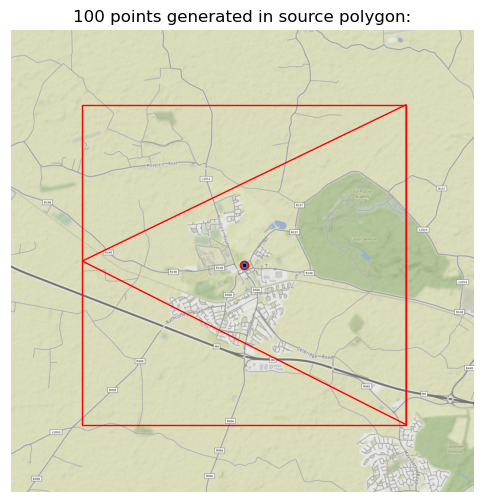

	Points plotted.
#####################################################################################
RADIAN generation complete.


In [47]:
radian_lite("scenarios/shape_testing/maynoothpolys.json", 100)